In [1]:
# =============================================================================
# Shopee Product Similarity Detection - Complete Pipeline (Fixed Version)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, silhouette_score, adjusted_rand_score, homogeneity_score, completeness_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from lightgbm import LGBMClassifier, early_stopping
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)


In [2]:

# =============================================================================
# Step 1: Data Loading and Initial Exploration
# =============================================================================

print("Step 1: Loading and exploring dataset...")

def load_and_explore_data(file_path):
    """
    Load dataset and perform initial exploration
    """
    # Load the prepared dataset
    df = pd.read_csv(file_path)
    
    # Display basic dataset information
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    if 'label_group' in df.columns:
        print(f"Number of unique label groups: {df['label_group'].nunique()}")
    
    # Analyze label group distribution
    if 'label_group' in df.columns:
        label_stats = df['label_group'].value_counts().describe()
        print("Sample size per label group statistics:")
        print(label_stats)
    
    # Check for missing values
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    # Check data types
    print("\nData types:")
    print(df.dtypes)
    
    return df

# Load data
merged = load_and_explore_data("shopee_dataset_final.csv")


Step 1: Loading and exploring dataset...
Dataset shape: (34250, 17)
Columns: ['posting_id', 'image', 'image_phash', 'title', 'label_group', 'title_clean', 'brand', 'category', 'title_norm', 'price', 'price_std', 'width', 'height', 'r', 'g', 'b', 'gray']
Number of unique label groups: 11014
Sample size per label group statistics:
count    11014.000000
mean         3.109679
std          2.940827
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         51.000000
Name: count, dtype: float64

Missing values per column:
posting_id     0
image          0
image_phash    0
title          0
label_group    0
title_clean    0
brand          0
category       0
title_norm     0
price          0
price_std      0
width          0
height         0
r              0
g              0
b              0
gray           0
dtype: int64

Data types:
posting_id      object
image           object
image_phash     object
title           object
label_group      int64
title_c

In [3]:

# =============================================================================
# Step 2: Data Preprocessing and Feature Encoding (Enhanced)
# =============================================================================

print("\nStep 2: Preprocessing and encoding categorical features...")

def preprocess_data(df):
    """
    Handle missing values and encode categorical features.
    Adds frequency encodings for brand/category to mitigate ordinal assumptions.
    """
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Handle missing values in categorical columns
    for col in ["brand", "category"]:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna("unknown").astype(str)
    
    # Encode brand and category features
    le_brand = LabelEncoder()
    le_category = LabelEncoder()

    if "brand" in df_processed.columns:
        df_processed["brand_encoded"] = le_brand.fit_transform(df_processed["brand"].astype(str))
        # Frequency encoding for brand
        brand_freq_map = df_processed["brand"].value_counts()
        df_processed["brand_freq"] = df_processed["brand"].map(brand_freq_map).astype(float)
    else:
        df_processed["brand_encoded"] = 0
        df_processed["brand_freq"] = 0.0
        le_brand.classes_ = np.array(["unknown"])  # minimal placeholder

    if "category" in df_processed.columns:
        df_processed["category_encoded"] = le_category.fit_transform(df_processed["category"].astype(str))
        # Frequency encoding for category (if exists)
        cat_freq_map = df_processed["category"].value_counts()
        df_processed["category_freq"] = df_processed["category"].map(cat_freq_map).astype(float)
    else:
        df_processed["category_encoded"] = 0
        df_processed["category_freq"] = 0.0
        le_category.classes_ = np.array(["unknown"])  # minimal placeholder

    print(f"Number of unique brands: {len(getattr(le_brand, 'classes_', []))}")
    print(f"Number of unique categories: {len(getattr(le_category, 'classes_', []))}")
    print("Added columns: 'brand_encoded', 'category_encoded', 'brand_freq', 'category_freq'")

    return df_processed, le_brand, le_category

merged_processed, le_brand, le_category = preprocess_data(merged)



Step 2: Preprocessing and encoding categorical features...
Number of unique brands: 419
Number of unique categories: 14
Added columns: 'brand_encoded', 'category_encoded', 'brand_freq', 'category_freq'


In [4]:

# =============================================================================
# Step 3: Multi-Modal Feature Integration (Enhanced)
# =============================================================================

print("\nStep 3: Integrating multi-modal features...")

def load_and_combine_features(df, use_image_embeddings=False, allow_placeholder=False, image_embedding_csv_path="eff_embeddings.csv"):
    """
    Load and combine text, image, and structured features.
    Ensures all features are numerical.
    - use_image_embeddings: whether to attempt loading image embeddings
    - allow_placeholder: if True, will create random placeholder when image embeddings are missing
    - image_embedding_csv_path: CSV file where the first column is posting_id and the rest are float features
    """
    features_list = []
    feature_descriptions = []

    # 1) Load text embeddings (Sentence-BERT) and align by posting_id if ids are available
    try:
        import os
        text_path = "./TF-IDF+SBERT/sentencebert_embeddings.npy"
        ids_path = "./TF-IDF+SBERT/sentencebert_ids.npy"
        text_emb = np.load(text_path)

        if 'posting_id' in df.columns and os.path.exists(ids_path):
            emb_ids = np.load(ids_path).astype(str)
            id_to_idx = {pid: i for i, pid in enumerate(emb_ids)}
            post_ids = df['posting_id'].astype(str).tolist()
            D = int(text_emb.shape[1]) if text_emb.ndim == 2 else 128
            aligned = np.zeros((len(post_ids), D), dtype=float)
            hit = 0
            for r, pid in enumerate(post_ids):
                j = id_to_idx.get(pid)
                if j is not None:
                    aligned[r] = text_emb[j]
                    hit += 1
            print(f"✓ Text embeddings aligned by posting_id: {hit}/{len(post_ids)} matched")
            text_emb = aligned
        else:
            # Fallback: ensure shape consistency or use placeholder
            if text_emb.ndim != 2:
                print("⚠ Warning: Text embeddings not 2D; using placeholder 128-dim.")
                text_emb = np.random.randn(len(df), 128)
            elif text_emb.shape[0] != len(df):
                print("⚠ Warning: Text embeddings count != number of rows; using placeholder with same dim.")
                text_emb = np.random.randn(len(df), text_emb.shape[1])

        print(f"✓ Text embeddings shape: {text_emb.shape}")
        features_list.append(text_emb)
        feature_descriptions.append(f"Text embeddings: {text_emb.shape[1]} dim")
    except FileNotFoundError:
        print("⚠ Warning: Text embeddings file not found.")
        # As a last resort, use a small random embedding to keep pipeline running
        text_emb = np.random.randn(len(df), 128)
        print("→ Using temporary random text embeddings (128 dim)")
        features_list.append(text_emb)
        feature_descriptions.append(f"Text embeddings (placeholder): {text_emb.shape[1]} dim")

    # 2) Extract numerical features from dataframe
    numerical_cols = []
    string_cols = []

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            numerical_cols.append(col)
        else:
            string_cols.append(col)

    print(f"Numerical columns: {numerical_cols}")
    print(f"Non-numerical columns: {string_cols}")

    # Select relevant numerical features (include new frequency encodings)
    usable_numerical_cols = [
        'price', 'price_std', 'width', 'height', 'r', 'g', 'b', 'gray',
        'brand_encoded', 'category_encoded', 'brand_freq', 'category_freq'
    ]

    # Filter to only include columns that exist in the dataframe
    available_numerical_cols = [col for col in usable_numerical_cols if col in df.columns]

    if available_numerical_cols:
        numerical_features = df[available_numerical_cols].values.astype(float)
        print(f"✓ Numerical features shape: {numerical_features.shape}")
        features_list.append(numerical_features)
        feature_descriptions.append(f"Numerical features: {numerical_features.shape[1]} dim")
    else:
        print("ℹ No selected numerical features found")

    # 3) Optionally load image embeddings (from CSV)
    image_embeddings_loaded = False

    if use_image_embeddings:
        try:
            # Load CSV where col0 is posting_id and the remaining are embedding dims
            emb_df = pd.read_csv(image_embedding_csv_path, header=None)
            if emb_df.shape[1] < 2:
                raise ValueError("Embedding CSV must have at least 2 columns: id and features.")
            emb_df = emb_df.rename(columns={0: 'posting_id'})
            emb_df['posting_id'] = emb_df['posting_id'].astype(str)
            # Normalize ids: add 'train_' prefix if missing (common in our data)
            emb_df['posting_id'] = emb_df['posting_id'].apply(lambda x: x if x.startswith('train_') or x.startswith('gen_') else f'train_{x}')
            feat_cols = [c for c in emb_df.columns if c != 'posting_id']
            for c in feat_cols:
                emb_df[c] = pd.to_numeric(emb_df[c], errors='coerce')
            # Align to df order via posting_id
            if 'posting_id' not in df.columns:
                raise KeyError("Dataframe must contain 'posting_id' to align image embeddings.")
            aligned = df[['posting_id']].merge(emb_df, on='posting_id', how='left')
            image_emb = aligned[feat_cols].fillna(0.0).values.astype(float)
            print(f"✓ Image embeddings (CSV) shape: {image_emb.shape}")
            features_list.append(image_emb)
            feature_descriptions.append(f"Image embeddings (CSV): {image_emb.shape[1]} dim")
            image_embeddings_loaded = True
        except FileNotFoundError:
            print(f"ℹ Image embedding CSV not found: {image_embedding_csv_path}")
        except Exception as e:
            print(f"⚠ Failed to load image embeddings from CSV: {e}")

        # If no image embeddings found
        if not image_embeddings_loaded and allow_placeholder:
            print("⚠ Warning: No image embeddings found. Using placeholder (512 dim).")
            image_placeholder = np.random.randn(len(df), 512)
            features_list.append(image_placeholder)
            feature_descriptions.append(f"Image embeddings (placeholder): {image_placeholder.shape[1]} dim")
        elif use_image_embeddings and not image_embeddings_loaded:
            print("↪ Skipping image embeddings (none found and placeholder disabled)")

    # 4) Concatenate all features
    if features_list:
        X_combined = np.concatenate(features_list, axis=1)
        print(f"✓ Final feature matrix shape: {X_combined.shape}")
        
        # Print feature composition
        print("\nFeature Composition:")
        for desc in feature_descriptions:
            print(f"  - {desc}")
        
        # Verify all features are numerical
        print(f"✓ All features are numerical: {np.issubdtype(X_combined.dtype, np.number)}")
        
    else:
        raise ValueError("No features were successfully loaded!")
    
    return X_combined

# Enable image embeddings from CSV by default
X_combined = load_and_combine_features(merged_processed, use_image_embeddings=True, allow_placeholder=False, image_embedding_csv_path="eff_embeddings.csv")



Step 3: Integrating multi-modal features...
✓ Text embeddings shape: (34250, 384)
Numerical columns: ['label_group', 'price', 'price_std', 'width', 'height', 'r', 'g', 'b', 'gray', 'brand_encoded', 'brand_freq', 'category_encoded', 'category_freq']
Non-numerical columns: ['posting_id', 'image', 'image_phash', 'title', 'title_clean', 'brand', 'category', 'title_norm']
✓ Numerical features shape: (34250, 12)
✓ Image embeddings (CSV) shape: (34250, 1280)
✓ Final feature matrix shape: (34250, 1676)

Feature Composition:
  - Text embeddings: 384 dim
  - Numerical features: 12 dim
  - Image embeddings (CSV): 1280 dim
✓ All features are numerical: True
✓ Image embeddings (CSV) shape: (34250, 1280)
✓ Final feature matrix shape: (34250, 1676)

Feature Composition:
  - Text embeddings: 384 dim
  - Numerical features: 12 dim
  - Image embeddings (CSV): 1280 dim
✓ All features are numerical: True


In [5]:

# =============================================================================
# Step 4: Data Preprocessing and Dimensionality Reduction (Helper)
# =============================================================================

print("\nStep 4: Data preprocessing helpers (no global fit to avoid leakage)...")

def preprocess_and_reduce_features(X, variance_threshold=0.95, scale_features=True):
    """
    Preprocess features and apply PCA for dimensionality reduction.
    This helper fits on the provided X. Use ONLY on training data to avoid leakage.
    """
    print(f"Original feature matrix shape: {X.shape}")
    print(f"Feature matrix dtype: {X.dtype}")
    
    # Check for any non-finite values
    if not np.isfinite(X).all():
        print("⚠ Warning: Feature matrix contains non-finite values. Replacing with zeros.")
        X = np.nan_to_num(X)
    
    # Feature scaling (optional but recommended for PCA)
    if scale_features:
        print("Applying feature scaling...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        print("✓ Feature scaling completed")
    else:
        X_scaled = X
        scaler = None
    
    # Apply PCA for dimensionality reduction
    print(f"Applying PCA to preserve {variance_threshold:.1%} variance...")
    pca = PCA(n_components=variance_threshold, random_state=42)
    X_reduced = pca.fit_transform(X_scaled)
    
    print(f"Reduced feature shape: {X_reduced.shape}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    print(f"Number of components: {pca.n_components_}")
    
    # Plot explained variance (training insight only)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Individual Component Variance')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return X_reduced, pca, scaler

# Note: No global call here. Fitting happens after the posting_id split in Step 4.5.



Step 4: Data preprocessing helpers (no global fit to avoid leakage)...


In [6]:

# =============================================================================
# Step 4.5: Split base items by posting_id and fit scaler/PCA on train only
# =============================================================================

print("\nStep 4.5: Splitting base items by posting_id (prevent leakage) and fitting PCA on train...")

def split_base_by_posting_id_and_fit(df, X_base, test_size=0.2, random_state=42, variance_threshold=0.95):
    """
    Leakage-safe split by posting_id, then fit scaler+PCA on train and transform both splits.
    Falls back to pair-level split with global PCA only if required columns are missing.
    """
    if 'posting_id' in df.columns and 'label_group' in df.columns:
        unique_ids = df['posting_id'].astype(str).unique()
        train_ids, test_ids = train_test_split(unique_ids, test_size=test_size, random_state=random_state)

        mask_train = df['posting_id'].astype(str).isin(train_ids).values
        mask_test = ~mask_train

        df_train = df.loc[mask_train].reset_index(drop=True)
        df_test = df.loc[mask_test].reset_index(drop=True)

        X_train_raw = X_base[mask_train]
        X_test_raw = X_base[mask_test]

        # Fit scaler + PCA on train only
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_raw)
        pca = PCA(n_components=variance_threshold, random_state=random_state)
        X_train_base = pca.fit_transform(X_train_scaled)

        # Transform test with train-fitted scaler+pca
        X_test_base = pca.transform(scaler.transform(X_test_raw))

        groups_train = df_train['label_group'].values
        groups_test = df_test['label_group'].values

        print(f"Train base items: {len(df_train)}, Test base items: {len(df_test)}")
        print(f"Base feature dim after PCA: {X_train_base.shape[1]} components")
        return X_train_base, X_test_base, groups_train, groups_test, df_train, df_test, scaler, pca, False
    else:
        # Fallback: cannot split by posting_id; do a one-off global PCA only for pair generation
        print("↪ 'posting_id' or 'label_group' not found. Using fallback: global PCA then pair-level split.")
        X_reduced, pca, scaler = preprocess_and_reduce_features(X_base, variance_threshold=variance_threshold)
        return None, None, None, None, None, None, scaler, pca, True

# Execute leakage-safe split + fit
X_train_base, X_test_base, groups_train, groups_test, df_train, df_test, scaler, pca, fallback_mode = split_base_by_posting_id_and_fit(
    merged_processed, X_combined, test_size=0.2, random_state=42, variance_threshold=0.95
)



Step 4.5: Splitting base items by posting_id (prevent leakage) and fitting PCA on train...
Train base items: 27400, Test base items: 6850
Base feature dim after PCA: 122 components
Train base items: 27400, Test base items: 6850
Base feature dim after PCA: 122 components



📊 Generating PCA dimensionality reduction visualizations...


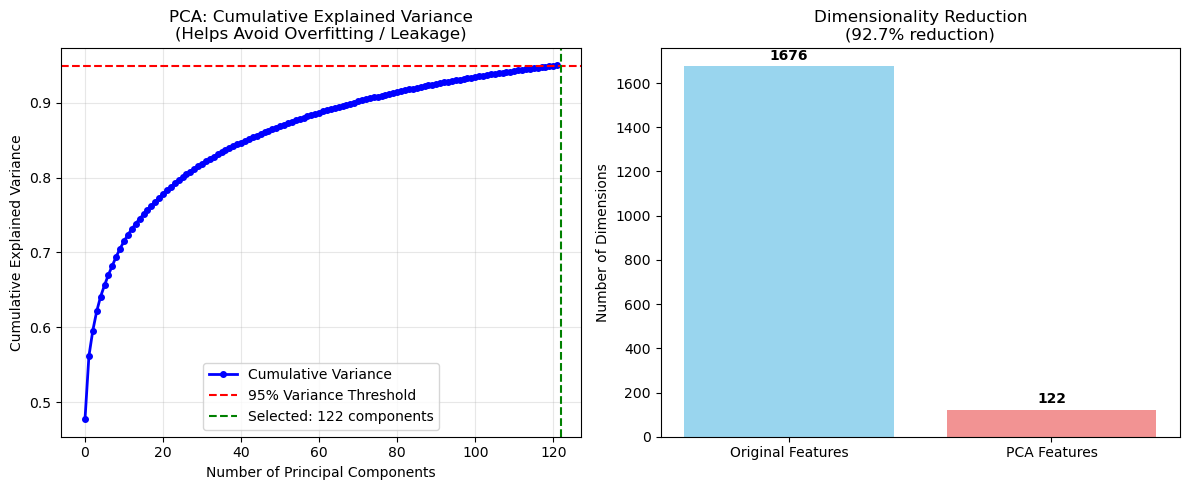

🔹 Original feature dimension: 1676
🔹 PCA reduced dimension: 122
🔹 Dimensionality reduction: 92.7%
🔹 Total retained variance: 0.9501


In [7]:
# PCA Dimensionality Reduction Visualization
# ------------------------------------------------------------
# This cell visualizes (1) the cumulative explained variance to assess
# how many principal components are needed and (2) the dimensionality
# reduction achieved by PCA. All comments are in English per request.

import numpy as np
import matplotlib.pyplot as plt

# Safety checks to avoid runtime errors if PCA or data are missing
if 'pca' not in globals():
    raise NameError("The PCA object 'pca' is not defined. Please fit PCA before running this cell.")
if 'X_combined' not in globals():
    raise NameError("The dataset 'X_combined' is not defined. Ensure it exists before visualization.")
if not hasattr(pca, 'explained_variance_ratio_'):
    raise AttributeError("The PCA object does not have 'explained_variance_ratio_'. Was it fitted?")

print("\n📊 Generating PCA dimensionality reduction visualizations...")

plt.figure(figsize=(12, 5))

# ------------------------------------------------------------
# Left Plot: Cumulative explained variance vs number of components
# ------------------------------------------------------------
plt.subplot(1, 2, 1)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, 'b-o', linewidth=2, markersize=4, label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=pca.n_components_, color='g', linestyle='--', 
            label=f'Selected: {pca.n_components_} components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance\n(Helps Avoid Overfitting / Leakage)')
plt.legend()
plt.grid(True, alpha=0.3)

# ------------------------------------------------------------
# Right Plot: Bar chart showing dimensionality reduction effect
# ------------------------------------------------------------
plt.subplot(1, 2, 2)
original_dim = X_combined.shape[1]
reduced_dim = pca.n_components_
categories = ['Original Features', 'PCA Features']
dimensions = [original_dim, reduced_dim]
colors = ['skyblue', 'lightcoral']
bars = plt.bar(categories, dimensions, color=colors, alpha=0.85)
plt.ylabel('Number of Dimensions')
reduction_pct = (1 - reduced_dim / original_dim) * 100
plt.title(f'Dimensionality Reduction\n({reduction_pct:.1f}% reduction)')

# Annotate each bar with the exact dimension count
for bar, value in zip(bars, dimensions):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + original_dim * 0.01,
             f'{value}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Print key PCA metrics for quick inspection
# ------------------------------------------------------------
print(f"🔹 Original feature dimension: {original_dim}")
print(f"🔹 PCA reduced dimension: {reduced_dim}")
print(f"🔹 Dimensionality reduction: {reduction_pct:.1f}%")
print(f"🔹 Total retained variance: {pca.explained_variance_ratio_.sum():.4f}")


In [8]:

# =============================================================================
# Step 5: Enhanced Pair Generation for Similarity Learning (Leakage-safe)
# =============================================================================

print("\nStep 5: Generating positive and negative pairs...")

from typing import Optional


def _phash_hamming_distance(h1, h2) -> float:
    try:
        if pd.isna(h1) or pd.isna(h2):
            return 0.0
        h1s = str(h1).strip()
        h2s = str(h2).strip()
        # Try hex-based hamming via integer XOR
        v = int(h1s, 16) ^ int(h2s, 16)
        return float(v.bit_count())
    except Exception:
        # Fallback: character-wise difference for equal-length strings
        if isinstance(h1, str) and isinstance(h2, str) and len(h1) == len(h2):
            return float(sum(ch1 != ch2 for ch1, ch2 in zip(h1, h2)))
        return 0.0


def _l2_normalize_rows(X: np.ndarray) -> np.ndarray:
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms = np.maximum(norms, 1e-12)
    return X / norms


def _estimate_hard_neg_threshold(X: np.ndarray, groups: np.ndarray, rng: np.random.RandomState, sample_size: int = 10000, q: float = 0.75) -> float:
    # Use L2-normalized dot product as cosine similarity for speed
    Xn = _l2_normalize_rows(X)
    idx = np.arange(len(Xn))
    sims = []
    tries = 0
    max_tries = sample_size * 10
    while len(sims) < sample_size and tries < max_tries:
        tries += 1
        i, j = rng.choice(idx, 2, replace=False)
        if groups[i] != groups[j]:
            cs = float(np.dot(Xn[i], Xn[j]))
            sims.append(cs)
    if not sims:
        return 0.3  # sensible default
    thr = float(np.percentile(sims, q * 100))
    print(f"Estimated hard-negative cosine threshold (q={q}): {thr:.3f}")
    return thr


def create_enhanced_similarity_pairs(
    X: np.ndarray,
    df: pd.DataFrame,
    groups: np.ndarray,
    max_positive_pairs_per_group: int = 2,
    hard_negative_threshold: Optional[float] = None,
    random_state: int = 42,
    threshold_quantile: float = 0.75,
):
    """
    Create balanced pairs for similarity learning with hard negative mining.
    Adds richer features: abs-diff, hadamard, dot, cosine, euclidean, manhattan,
    same-brand, same-category, optional phash distance.
    """
    rng = np.random.RandomState(random_state)
    pairs = []
    labels = []

    print(f"Total items: {len(X)}, Unique groups: {len(np.unique(groups))}")

    # Precompute normalized features for fast cosine similarity
    Xn = _l2_normalize_rows(X)

    # Determine threshold if not provided
    if hard_negative_threshold is None:
        hard_negative_threshold = _estimate_hard_neg_threshold(X, groups, rng, sample_size=min(5000, len(X) * 2), q=threshold_quantile)

    # Generate positive pairs (same label group)
    print("Generating positive pairs...")
    positive_count = 0

    unique_group_ids = np.unique(groups)
    for group_id in unique_group_ids:
        group_indices = np.where(groups == group_id)[0]
        if len(group_indices) > 1:
            max_pairs = min(max_positive_pairs_per_group, len(group_indices) - 1)
            created_pairs = 0

            # Strategy 1: adjacent indices
            for i in range(len(group_indices) - 1):
                if created_pairs >= max_pairs:
                    break
                idx1 = group_indices[i]
                idx2 = group_indices[i + 1]

                feature_diff = np.abs(X[idx1] - X[idx2])
                hadamard = X[idx1] * X[idx2]
                cosine_sim = float(np.dot(Xn[idx1], Xn[idx2]))
                euclidean_dist = np.linalg.norm(X[idx1] - X[idx2])
                manhattan_dist = np.sum(np.abs(X[idx1] - X[idx2]))
                dot_product = float(np.dot(X[idx1], X[idx2]))

                same_brand = 0.0
                same_category = 0.0
                if 'brand_encoded' in df.columns:
                    same_brand = float(df.iloc[idx1]['brand_encoded'] == df.iloc[idx2]['brand_encoded'])
                if 'category_encoded' in df.columns:
                    same_category = float(df.iloc[idx1]['category_encoded'] == df.iloc[idx2]['category_encoded'])

                phash_dist = 0.0
                if 'image_phash' in df.columns:
                    phash_dist = _phash_hamming_distance(df.iloc[idx1].get('image_phash', None), df.iloc[idx2].get('image_phash', None))

                pair_features = np.concatenate([
                    feature_diff,
                    hadamard,
                    [cosine_sim, euclidean_dist, manhattan_dist, dot_product, same_brand, same_category, phash_dist]
                ])

                pairs.append(pair_features)
                labels.append(1)
                positive_count += 1
                created_pairs += 1

            # Strategy 2: random within group if need more
            attempts = 0
            while created_pairs < max_pairs and len(group_indices) > 2 and attempts < 50:
                attempts += 1
                idx1, idx2 = rng.choice(group_indices, 2, replace=False)
                if idx1 == idx2:
                    continue
                feature_diff = np.abs(X[idx1] - X[idx2])
                hadamard = X[idx1] * X[idx2]
                cosine_sim = float(np.dot(Xn[idx1], Xn[idx2]))
                euclidean_dist = np.linalg.norm(X[idx1] - X[idx2])
                manhattan_dist = np.sum(np.abs(X[idx1] - X[idx2]))
                dot_product = float(np.dot(X[idx1], X[idx2]))

                same_brand = 0.0
                same_category = 0.0
                if 'brand_encoded' in df.columns:
                    same_brand = float(df.iloc[idx1]['brand_encoded'] == df.iloc[idx2]['brand_encoded'])
                if 'category_encoded' in df.columns:
                    same_category = float(df.iloc[idx1]['category_encoded'] == df.iloc[idx2]['category_encoded'])

                phash_dist = 0.0
                if 'image_phash' in df.columns:
                    phash_dist = _phash_hamming_distance(df.iloc[idx1].get('image_phash', None), df.iloc[idx2].get('image_phash', None))

                pair_features = np.concatenate([
                    feature_diff,
                    hadamard,
                    [cosine_sim, euclidean_dist, manhattan_dist, dot_product, same_brand, same_category, phash_dist]
                ])

                pairs.append(pair_features)
                labels.append(1)
                positive_count += 1
                created_pairs += 1

    print(f"✓ Generated {positive_count} positive pairs")

    # Generate negative pairs (different label groups)
    print("Generating negative pairs...")
    negative_count = 0
    target_negative_count = positive_count  # Balance classes

    # Build index lists per group
    group_to_indices = {gid: np.where(groups == gid)[0] for gid in unique_group_ids}
    group_ids = list(group_to_indices.keys())

    attempts = 0
    max_attempts = max(1, target_negative_count * 20)

    while negative_count < target_negative_count and attempts < max_attempts:
        attempts += 1
        g1, g2 = rng.choice(group_ids, 2, replace=False)
        idx1 = rng.choice(group_to_indices[g1])
        idx2 = rng.choice(group_to_indices[g2])

        cosine_sim = float(np.dot(Xn[idx1], Xn[idx2]))
        # Include hard negatives (similar but different groups) and some random negatives
        if cosine_sim > hard_negative_threshold or rng.random() < 0.3:
            feature_diff = np.abs(X[idx1] - X[idx2])
            hadamard = X[idx1] * X[idx2]
            euclidean_dist = np.linalg.norm(X[idx1] - X[idx2])
            manhattan_dist = np.sum(np.abs(X[idx1] - X[idx2]))
            dot_product = float(np.dot(X[idx1], X[idx2]))

            same_brand = 0.0
            same_category = 0.0
            if 'brand_encoded' in df.columns:
                same_brand = float(df.iloc[idx1]['brand_encoded'] == df.iloc[idx2]['brand_encoded'])
            if 'category_encoded' in df.columns:
                same_category = float(df.iloc[idx1]['category_encoded'] == df.iloc[idx2]['category_encoded'])

            phash_dist = 0.0
            if 'image_phash' in df.columns:
                phash_dist = _phash_hamming_distance(df.iloc[idx1].get('image_phash', None), df.iloc[idx2].get('image_phash', None))

            pair_features = np.concatenate([
                feature_diff,
                hadamard,
                [cosine_sim, euclidean_dist, manhattan_dist, dot_product, same_brand, same_category, phash_dist]
            ])

            pairs.append(pair_features)
            labels.append(0)
            negative_count += 1

    if len(pairs) == 0:
        raise ValueError("No pairs were generated. Check your input data and parameters.")

    print(f"✓ Generated {negative_count} negative pairs")
    print(f"✓ Total pairs: {len(pairs)}")
    print(f"✓ Label distribution: {np.bincount(labels)}")
    print(f"✓ Pair feature dimension: {len(pairs[0]) if pairs else 0}")

    return np.array(pairs), np.array(labels)

# Create similarity pairs with leakage-safe split if available
if not 'fallback_mode' in globals():
    fallback_mode = True

if not fallback_mode:
    # Train pairs
    X_pairs_train, y_pairs_train = create_enhanced_similarity_pairs(
        X_train_base,
        df_train,
        groups_train,
        max_positive_pairs_per_group=2,
        hard_negative_threshold=None,
        random_state=42,
        threshold_quantile=0.75,
    )
    # Test pairs
    X_pairs_test, y_pairs_test = create_enhanced_similarity_pairs(
        X_test_base,
        df_test,
        groups_test,
        max_positive_pairs_per_group=2,
        hard_negative_threshold=None,
        random_state=42,
        threshold_quantile=0.75,
    )
else:
    print("Using fallback mode: will generate pairs on full data; split later.")
    groups = merged_processed["label_group"].values if 'label_group' in merged_processed.columns else np.zeros(len(merged_processed), dtype=int)
    X_pairs, y_pairs = create_enhanced_similarity_pairs(
        X_reduced,
        merged_processed,
        groups,
        max_positive_pairs_per_group=2,
        hard_negative_threshold=None,
        random_state=42,
        threshold_quantile=0.75,
    )



Step 5: Generating positive and negative pairs...
Total items: 27400, Unique groups: 10717
Estimated hard-negative cosine threshold (q=0.75): 0.293
Generating positive pairs...
Estimated hard-negative cosine threshold (q=0.75): 0.293
Generating positive pairs...
✓ Generated 11267 positive pairs
Generating negative pairs...
✓ Generated 11267 positive pairs
Generating negative pairs...
✓ Generated 11267 negative pairs
✓ Total pairs: 22534
✓ Label distribution: [11267 11267]
✓ Pair feature dimension: 251
Total items: 6850, Unique groups: 4993
✓ Generated 11267 negative pairs
✓ Total pairs: 22534
✓ Label distribution: [11267 11267]
✓ Pair feature dimension: 251
Total items: 6850, Unique groups: 4993
Estimated hard-negative cosine threshold (q=0.75): 0.292
Generating positive pairs...
✓ Generated 1557 positive pairs
Generating negative pairs...
Estimated hard-negative cosine threshold (q=0.75): 0.292
Generating positive pairs...
✓ Generated 1557 positive pairs
Generating negative pairs...


In [9]:

# =============================================================================
# Step 6: Train-Test Assignment (uses leakage-safe pairs if available)
# =============================================================================

print("\nStep 6: Preparing training and testing sets...")

if 'X_pairs_train' in globals() and 'X_pairs_test' in globals():
    X_train, X_test = X_pairs_train, X_pairs_test
    y_train, y_test = y_pairs_train, y_pairs_test
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Train distribution: {np.bincount(y_train)}")
    print(f"Test distribution: {np.bincount(y_test)}")
else:
    print("Leakage-safe pairs not found. Performing stratified split on generated pairs (fallback mode)...")
    if 'X_pairs' not in globals() or 'y_pairs' not in globals():
        raise ValueError("Fallback requires X_pairs and y_pairs to be defined.")

    def split_data_stratified(X, y, test_size=0.2, random_state=42):
        if len(X) == 0:
            raise ValueError("No pairs generated for training!")
        X_tr, X_te, y_tr, y_te = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        print(f"Training set shape: {X_tr.shape}")
        print(f"Test set shape: {X_te.shape}")
        print(f"Train distribution: {np.bincount(y_tr)}")
        print(f"Test distribution: {np.bincount(y_te)}")
        return X_tr, X_te, y_tr, y_te

    X_train, X_test, y_train, y_test = split_data_stratified(X_pairs, y_pairs)



Step 6: Preparing training and testing sets...
Training set shape: (22534, 251)
Test set shape: (3114, 251)
Train distribution: [11267 11267]
Test distribution: [1557 1557]


In [10]:

# =============================================================================
# Step 7: Model Training with Cross-Validation
# =============================================================================

print("\nStep 7: Training LightGBM classifier with cross-validation...")

def train_with_cross_validation(X_train, y_train, n_splits=3, random_state=42):  # Reduced to 3 for speed
    """
    Train model with stratified k-fold cross-validation
    """
    # Initialize LightGBM classifier
    lgb_model = LGBMClassifier(
        random_state=random_state,
        n_jobs=-1,
        class_weight='balanced',
        verbose=-1
    )
    
    # Perform cross-validation
    print("Performing cross-validation...")
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_scores = []
    fold_models = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"Training fold {fold+1}/{n_splits}...")
        
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        
        # Train model with early stopping
        lgb_model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric='binary_logloss',
            callbacks=[early_stopping(stopping_rounds=30, verbose=False)]  # Reduced for speed
        )
        
        # Predict and calculate F1-score
        y_pred = lgb_model.predict(X_val)
        fold_f1 = f1_score(y_val, y_pred)
        cv_scores.append(fold_f1)
        fold_models.append(lgb_model)
        
        print(f"Fold {fold+1} F1-score: {fold_f1:.4f}")
    
    print(f"✓ Cross-validation F1-score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    
    return np.mean(cv_scores), fold_models

cv_score, fold_models = train_with_cross_validation(X_train, y_train)



Step 7: Training LightGBM classifier with cross-validation...
Performing cross-validation...
Training fold 1/3...
Fold 1 F1-score: 0.9472
Training fold 2/3...
Fold 1 F1-score: 0.9472
Training fold 2/3...
Fold 2 F1-score: 0.9458
Training fold 3/3...
Fold 2 F1-score: 0.9458
Training fold 3/3...
Fold 3 F1-score: 0.9526
✓ Cross-validation F1-score: 0.9485 ± 0.0029
Fold 3 F1-score: 0.9526
✓ Cross-validation F1-score: 0.9485 ± 0.0029


In [11]:

# =============================================================================
# Step 8: Hyperparameter Tuning with Randomized Search
# =============================================================================

print("\nStep 8: Performing hyperparameter tuning...")

def perform_hyperparameter_tuning(X_train, y_train, n_iter=10, cv=2, random_state=42):  # Reduced for speed
    """
    Perform randomized search for hyperparameter optimization
    """
    # Define parameter distribution (simplified for speed)
    param_dist = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 63],
        'max_depth': [10, 15],
        'min_child_samples': [50, 100],
        'subsample': [0.8, 0.9]
    }
    
    # Perform randomized search
    print("Starting randomized search...")
    random_search = RandomizedSearchCV(
        LGBMClassifier(random_state=random_state, n_jobs=-1, class_weight='balanced', verbose=-1),
        param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    # Display best parameters
    print("✓ Best parameters found:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"✓ Best cross-validation F1-score: {random_search.best_score_:.4f}")
    
    return random_search

random_search = perform_hyperparameter_tuning(X_train, y_train)



Step 8: Performing hyperparameter tuning...
Starting randomized search...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
✓ Best parameters found:
  subsample: 0.9
  num_leaves: 31
  n_estimators: 200
  min_child_samples: 100
  max_depth: 15
  learning_rate: 0.1
✓ Best cross-validation F1-score: 0.9505
✓ Best parameters found:
  subsample: 0.9
  num_leaves: 31
  n_estimators: 200
  min_child_samples: 100
  max_depth: 15
  learning_rate: 0.1
✓ Best cross-validation F1-score: 0.9505


In [12]:

# =============================================================================
# Step 9: Final Model Training
# =============================================================================

print("\nStep 9: Training final model with best parameters...")

def train_final_model(X_train, y_train, best_params, random_state=42):
    """
    Train final model with best parameters and early stopping
    """
    # Create validation split for early stopping
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
        X_train, y_train, test_size=0.2, random_state=random_state, stratify=y_train
    )
    
    # Initialize model with best parameters
    best_clf = LGBMClassifier(**best_params, random_state=random_state, verbose=-1)
    
    # Train with early stopping
    print("Training final model...")
    best_clf.fit(
        X_train_final, y_train_final,
        eval_set=[(X_val_final, y_val_final)],
        eval_metric='binary_logloss',
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    print("✓ Final model training completed")
    return best_clf

best_clf = train_final_model(X_train, y_train, random_search.best_params_)



Step 9: Training final model with best parameters...
Training final model...
Training final model...
✓ Final model training completed
✓ Final model training completed


In [13]:

# =============================================================================
# Step 10: Model Evaluation
# =============================================================================

print("\nStep 10: Evaluating model performance...")

def evaluate_model(model, X_test, y_test):
    """
    Comprehensive model evaluation with multiple metrics
    """
    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = (y_pred == y_test).mean()
    
    print("\n" + "="*50)
    print("MODEL PERFORMANCE RESULTS")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Confusion matrices (rows=true, cols=pred), fixed label order [0,1]
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    cm_norm = confusion_matrix(y_test, y_pred, labels=[0, 1], normalize='true')
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)
    print("Confusion matrix normalized by true labels (recall per class):")
    print(cm_norm)
    
    return y_pred, y_pred_proba, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'confusion_matrix_norm': cm_norm,
    }

y_pred, y_pred_proba, metrics = evaluate_model(best_clf, X_test, y_test)



Step 10: Evaluating model performance...

MODEL PERFORMANCE RESULTS
Accuracy: 0.9544
Precision: 0.9714
Recall: 0.9364
F1-score: 0.9536

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.97      0.96      1557
    Positive       0.97      0.94      0.95      1557

    accuracy                           0.95      3114
   macro avg       0.95      0.95      0.95      3114
weighted avg       0.95      0.95      0.95      3114


MODEL PERFORMANCE RESULTS
Accuracy: 0.9544
Precision: 0.9714
Recall: 0.9364
F1-score: 0.9536

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.97      0.96      1557
    Positive       0.97      0.94      0.95      1557

    accuracy                           0.95      3114
   macro avg       0.95      0.95      0.95      3114
weighted avg       0.95      0.95      0.95      3114

Confusion matrix (rows=true, cols=pred):
[[1514   


Step 11: Generating visualizations and analysis...


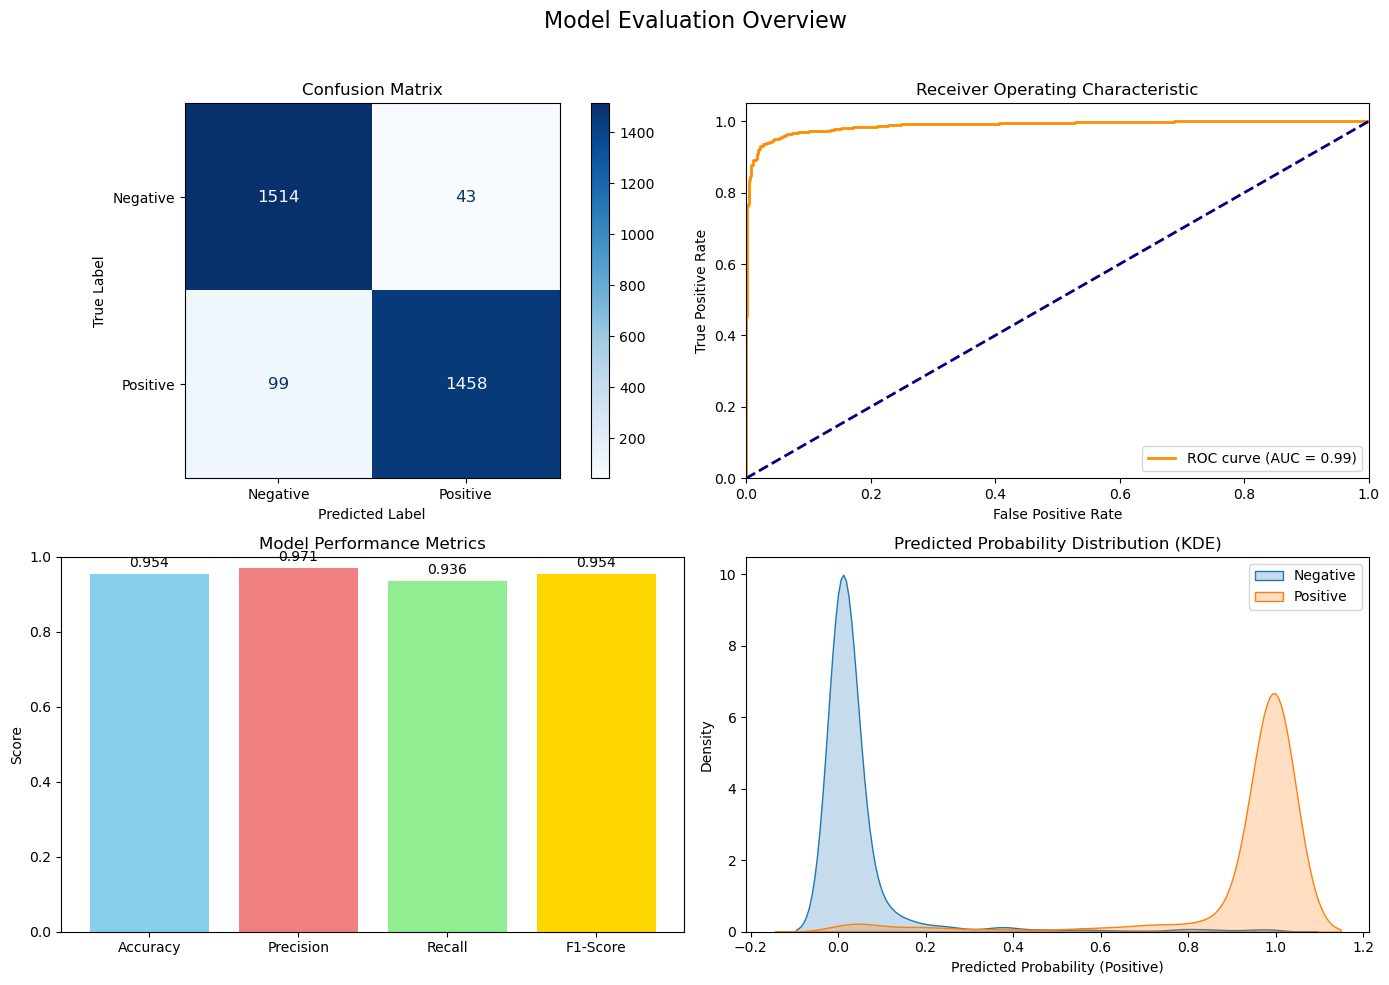

In [14]:
# =============================================================================
# Step 11: Visualization and Analysis (2x2 Grid Layout)
# =============================================================================

print("\nStep 11: Generating visualizations and analysis...")

def create_visualizations(y_test, y_pred, y_pred_proba, metrics):
    """
    Create comprehensive visualizations for model analysis in a 2x2 grid:
      (1) Confusion Matrix
      (2) ROC Curve
      (3) Performance Metrics Bar Chart
      (4) Predicted Probability Distribution (KDE or fallback Histogram)
    Returns ROC AUC.
    """
    # Create 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Model Evaluation Overview', fontsize=16, y=0.98)

    # ------------------------------------------------------------
    # (1) Confusion Matrix
    # ------------------------------------------------------------
    ax_cm = axes[0, 0]
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive'])
    disp.plot(ax=ax_cm, cmap='Blues', colorbar=True, values_format='d')
    ax_cm.set_title('Confusion Matrix')
    ax_cm.set_xlabel('Predicted Label')
    ax_cm.set_ylabel('True Label')
    for t in disp.ax_.texts:  # improve text visibility
        t.set_fontsize(12)

    # ------------------------------------------------------------
    # (2) ROC Curve
    # ------------------------------------------------------------
    ax_roc = axes[0, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.legend(loc='lower right')

    # ------------------------------------------------------------
    # (3) Metrics Bar Chart
    # ------------------------------------------------------------
    ax_metrics = axes[1, 0]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metric_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']]
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
    bars = ax_metrics.bar(metric_names, metric_values, color=colors)
    ax_metrics.set_ylim(0, 1)
    ax_metrics.set_title('Model Performance Metrics')
    ax_metrics.set_ylabel('Score')
    for bar, v in zip(bars, metric_values):
        ax_metrics.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{v:.3f}', ha='center', va='bottom')

    # ------------------------------------------------------------
    # (4) Predicted Probability Distribution
    # ------------------------------------------------------------
    ax_prob = axes[1, 1]
    try:
        sns.kdeplot(y_pred_proba[np.array(y_test) == 0], fill=True, label='Negative', ax=ax_prob)
        sns.kdeplot(y_pred_proba[np.array(y_test) == 1], fill=True, label='Positive', ax=ax_prob)
        ax_prob.set_title('Predicted Probability Distribution (KDE)')
    except Exception:
        ax_prob.hist(y_pred_proba[np.array(y_test) == 0], bins=30, alpha=0.6, label='Negative')
        ax_prob.hist(y_pred_proba[np.array(y_test) == 1], bins=30, alpha=0.6, label='Positive')
        ax_prob.set_title('Predicted Probability Histogram')
    ax_prob.set_xlabel('Predicted Probability (Positive)')
    ax_prob.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    return roc_auc

roc_auc = create_visualizations(y_test, y_pred, y_pred_proba, metrics)



Step 12: Analyzing feature importance...
Top 15 most important features:
Manhattan_Distance: 112.0000
Phash_Distance: 75.0000
Hadamard_0: 73.0000
Same_Category: 64.0000
Hadamard_3: 55.0000
Same_Brand: 55.0000
Hadamard_12: 52.0000
Hadamard_35: 49.0000
Hadamard_26: 47.0000
Hadamard_61: 47.0000
Hadamard_32: 45.0000
Hadamard_97: 44.0000
Hadamard_59: 43.0000
Hadamard_22: 42.0000
Hadamard_50: 42.0000


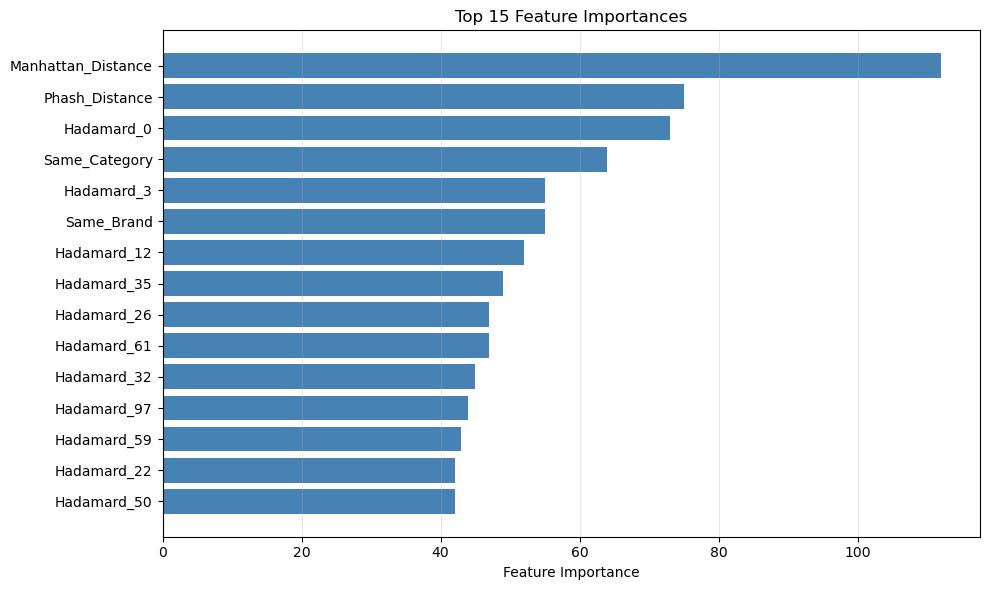

In [15]:

# =============================================================================
# Step 12: Feature Importance Analysis
# =============================================================================

print("\nStep 12: Analyzing feature importance...")

def analyze_feature_importance(model, base_feature_dim, pair_feature_dim, top_n=15):
    """
    Analyze and visualize feature importance with improved naming.
    pair features layout: [|Diff| (D), |Hadamard| (D), Cosine, Euclidean, Manhattan, Dot, SameBrand, SameCategory, PhashDist]
    """
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1]

    # Build feature names
    D = int(base_feature_dim)
    names = []
    names.extend([f'Diff_{i}' for i in range(D)])
    names.extend([f'Hadamard_{i}' for i in range(D)])
    names.extend(['Cosine_Similarity', 'Euclidean_Distance', 'Manhattan_Distance', 'Dot_Product', 'Same_Brand', 'Same_Category', 'Phash_Distance'])

    # Adjust if lengths mismatch
    if len(names) != pair_feature_dim:
        print(f"ℹ Warning: Expected {pair_feature_dim} feature names, built {len(names)}. Truncating/Extending as needed.")
        if len(names) < pair_feature_dim:
            names.extend([f'Feature_{i}' for i in range(len(names), pair_feature_dim)])
        else:
            names = names[:pair_feature_dim]

    print(f"Top {top_n} most important features:")
    for i in range(min(top_n, len(feature_importance))):
        feat_idx = sorted_idx[i]
        feat_name = names[feat_idx] if feat_idx < len(names) else f'Feature_{feat_idx}'
        print(f"{feat_name}: {feature_importance[feat_idx]:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = min(top_n, len(feature_importance))
    indices = sorted_idx[:top_features]

    feature_labels = [names[i] if i < len(names) else f'Feature_{i}' for i in indices]

    plt.barh(range(top_features), feature_importance[indices], color='steelblue')
    plt.yticks(range(top_features), feature_labels)
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_features} Feature Importances')
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

pair_feature_dim_current = X_train.shape[1]
base_feature_dim_current = (X_train_base.shape[1] if 'X_train_base' in globals() else X_reduced.shape[1])
analyze_feature_importance(best_clf, base_feature_dim_current, pair_feature_dim_current)


In [16]:

# =============================================================================
# Step 13: Business Insights and Error Analysis
# =============================================================================

print("\nStep 13: Generating business insights...")

def generate_business_insights(y_test, y_pred, y_pred_proba):
    """
    Generate business-oriented insights and error analysis
    """
    # Calculate error types
    fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]
    fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]
    
    total_samples = len(y_test)
    
    print("\n" + "="*50)
    print("BUSINESS INSIGHTS")
    print("="*50)
    print(f"Overall Accuracy: {(y_pred == y_test).mean():.2%}")
    print(f"False Positives: {len(fp_indices)} ({len(fp_indices)/total_samples:.2%})")
    print(f"False Negatives: {len(fn_indices)} ({len(fn_indices)/total_samples:.2%})")
    
    print(f"\nPrecision-Recall Analysis:")
    print(f"• High precision means when we predict 'similar', we're correct most of the time")
    print(f"• High recall means we identify most of the actual similar pairs")
    
    # Confidence analysis
    confidence_thresholds = [0.6, 0.7, 0.8, 0.9]
    print(f"\nPrediction Confidence Analysis:")
    for threshold in confidence_thresholds:
        high_conf_indices = np.where(y_pred_proba > threshold)[0]
        if len(high_conf_indices) > 0:
            high_conf_accuracy = (y_pred[high_conf_indices] == y_test[high_conf_indices]).mean()
            print(f"• Threshold {threshold}: {len(high_conf_indices)} samples ({len(high_conf_indices)/total_samples:.2%}), Accuracy: {high_conf_accuracy:.2%}")

generate_business_insights(y_test, y_pred, y_pred_proba)



Step 13: Generating business insights...

BUSINESS INSIGHTS
Overall Accuracy: 95.44%
False Positives: 43 (1.38%)
False Negatives: 99 (3.18%)

Precision-Recall Analysis:
• High precision means when we predict 'similar', we're correct most of the time
• High recall means we identify most of the actual similar pairs

Prediction Confidence Analysis:
• Threshold 0.6: 1477 samples (47.43%), Accuracy: 97.70%
• Threshold 0.7: 1452 samples (46.63%), Accuracy: 98.00%
• Threshold 0.8: 1407 samples (45.18%), Accuracy: 98.58%
• Threshold 0.9: 1347 samples (43.26%), Accuracy: 99.18%


In [17]:

# =============================================================================
# Step 14: Model Saving and Deployment Preparation
# =============================================================================

print("\nStep 14: Preparing model for deployment...")

def save_model_artifacts(model, pca, scaler, label_encoders, feature_info, filename='shopee_similarity_model.pkl'):
    """
    Save all model artifacts for deployment
    """
    model_assets = {
        'model': model,
        'pca': pca,
        'scaler': scaler,
        'label_encoder_brand': le_brand,
        'label_encoder_category': le_category,
        'feature_info': feature_info,
        'metadata': {
            'training_date': pd.Timestamp.now(),
            'model_type': 'LightGBM',
            'feature_dimension': (int(pca.n_components_) if pca is not None else int(feature_info.get('reduced_dim', 0))),
            'performance_metrics': metrics,
            'roc_auc': roc_auc
        }
    }
    
    joblib.dump(model_assets, filename)
    print(f"✓ Model and preprocessing assets saved to '{filename}'")
    
    return model_assets

# Save model artifacts
feature_info = {
    'original_dim': X_combined.shape[1],
    'reduced_dim': (int(pca.n_components_) if 'pca' in globals() and pca is not None else int(X_reduced.shape[1]) if 'X_reduced' in globals() else None),
    'pair_feature_dim': X_train.shape[1]
}

model_assets = save_model_artifacts(
    best_clf, 
    pca if 'pca' in globals() else None, 
    scaler if 'scaler' in globals() else None,
    {'brand': le_brand, 'category': le_category},
    feature_info
)



Step 14: Preparing model for deployment...
✓ Model and preprocessing assets saved to 'shopee_similarity_model.pkl'
✓ Model and preprocessing assets saved to 'shopee_similarity_model.pkl'


In [18]:

# =============================================================================
# Final Summary
# =============================================================================

print("\n" + "="*60)
print("TRAINING COMPLETE - SUMMARY")
print("="*60)
print(f"Dataset: {merged.shape[0]} samples, {merged.shape[1]} features")
print(f"Feature space: {X_combined.shape[1]} → {(int(pca.n_components_) if 'pca' in globals() and pca is not None else int(X_reduced.shape[1]) if 'X_reduced' in globals() else 'N/A')} dimensions after PCA")
print(f"Training pairs: {X_train.shape[0]} (balanced positive/negative)")
print(f"Test pairs: {X_test.shape[0]}")
print(f"Final Model Performance:")
print(f"  • F1-score: {metrics['f1']:.4f}")
print(f"  • Precision: {metrics['precision']:.4f}")
print(f"  • Recall: {metrics['recall']:.4f}")
print(f"  • Accuracy: {metrics['accuracy']:.4f}")
print(f"  • ROC AUC: {roc_auc:.4f}")
print(f"Model saved: shopee_similarity_model.pkl")
print("="*60)



TRAINING COMPLETE - SUMMARY
Dataset: 34250 samples, 17 features
Feature space: 1676 → 122 dimensions after PCA
Training pairs: 22534 (balanced positive/negative)
Test pairs: 3114
Final Model Performance:
  • F1-score: 0.9536
  • Precision: 0.9714
  • Recall: 0.9364
  • Accuracy: 0.9544
  • ROC AUC: 0.9883
Model saved: shopee_similarity_model.pkl


---

In [19]:
# =============================================================================
# Ablation Study (Text / Numeric / Image) - Config & Utilities
# =============================================================================

# ==== Configuration ====
RANDOM_STATE = 42
IMAGE_EMBEDDING_CSV_PATH = "eff_embeddings.csv"  # Set to None if not using external image embeddings CSV
STRICT_FIT_ON_TRAIN_ITEMS = True  # True: fit scaler/PCA only on items appearing in train_pairs (stricter)

# ==== Dependencies ====
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
from lightgbm import LGBMClassifier


In [20]:

# -----------------------------------------------------------------------------
# Modal feature combiner compatible with current notebook
# -----------------------------------------------------------------------------

def combine_modalities(
    df_items: pd.DataFrame,
    use_image_embeddings: bool,
    use_text_embeddings: bool,
    use_numeric_features: bool,
    image_embedding_csv_path: str | None = IMAGE_EMBEDDING_CSV_PATH,
):
    """
    Build a feature matrix by selecting among modalities (text / numeric / image).
    - Text: Loads SBERT embeddings from ./TF-IDF+SBERT/sentencebert_embeddings.npy and aligns by posting_id if available.
    - Numeric: Uses the same numeric columns as earlier cells (price/size/color/brand/category encodings & frequencies).
    - Image: Optionally loads image embeddings from CSV where col0=posting_id and rest are feature dims; aligns by posting_id.

    Returns
    -------
    X : np.ndarray, shape (n_items, n_features)
        Concatenated features for enabled modalities only.
    """
    features_list = []

    # 1) Text embeddings (Sentence-BERT)
    if use_text_embeddings:
        try:
            text_path = "./TF-IDF+SBERT/sentencebert_embeddings.npy"
            ids_path = "./TF-IDF+SBERT/sentencebert_ids.npy"
            text_emb = np.load(text_path)
            if text_emb.ndim != 2:
                # Fallback to placeholder
                text_emb = np.random.randn(len(df_items), 128)
            if 'posting_id' in df_items.columns and os.path.exists(ids_path):
                emb_ids = np.load(ids_path).astype(str)
                id_to_idx = {pid: i for i, pid in enumerate(emb_ids)}
                post_ids = df_items['posting_id'].astype(str).tolist()
                D = int(text_emb.shape[1])
                aligned = np.zeros((len(post_ids), D), dtype=float)
                hit = 0
                for r, pid in enumerate(post_ids):
                    j = id_to_idx.get(pid)
                    if j is not None:
                        aligned[r] = text_emb[j]
                        hit += 1
                # print(f"Text embeddings aligned by posting_id: {hit}/{len(post_ids)} matched")
                text_emb = aligned
            else:
                if text_emb.shape[0] != len(df_items):
                    text_emb = np.random.randn(len(df_items), text_emb.shape[1])
            features_list.append(text_emb.astype(float))
        except FileNotFoundError:
            # Placeholder if not found
            text_emb = np.random.randn(len(df_items), 128)
            features_list.append(text_emb.astype(float))

    # 2) Numeric features
    if use_numeric_features:
        usable_numerical_cols = [
            'price', 'price_std', 'width', 'height', 'r', 'g', 'b', 'gray',
            'brand_encoded', 'category_encoded', 'brand_freq', 'category_freq'
        ]
        available_numerical_cols = [c for c in usable_numerical_cols if c in df_items.columns]
        if available_numerical_cols:
            num_feats = df_items[available_numerical_cols].values.astype(float)
            features_list.append(num_feats)

    # 3) Image embeddings from CSV
    if use_image_embeddings and image_embedding_csv_path is not None:
        try:
            emb_df = pd.read_csv(image_embedding_csv_path, header=None)
            if emb_df.shape[1] < 2:
                raise ValueError("Embedding CSV must have at least 2 columns: id and features.")
            emb_df = emb_df.rename(columns={0: 'posting_id'})
            emb_df['posting_id'] = emb_df['posting_id'].astype(str)
            emb_df['posting_id'] = emb_df['posting_id'].apply(
                lambda x: x if x.startswith('train_') or x.startswith('gen_') else f'train_{x}'
            )
            feat_cols = [c for c in emb_df.columns if c != 'posting_id']
            for c in feat_cols:
                emb_df[c] = pd.to_numeric(emb_df[c], errors='coerce')
            if 'posting_id' not in df_items.columns:
                raise KeyError("DataFrame must contain 'posting_id' to align image embeddings.")
            aligned = df_items[['posting_id']].astype(str).merge(emb_df, on='posting_id', how='left')
            image_emb = aligned[feat_cols].fillna(0.0).values.astype(float)
            features_list.append(image_emb)
        except Exception as e:
            # If not available, skip image modality silently
            # print(f"Skip image embeddings: {e}")
            pass

    if not features_list:
        raise ValueError("No modalities enabled. Enable at least one of text/numeric/image.")

    X = np.concatenate(features_list, axis=1)
    return X


In [21]:

# Expose combiner via COMBINE_FN symbol used below
COMBINE_FN = combine_modalities


In [22]:

# -----------------------------------------------------------------------------
# Pair feature construction helpers
# -----------------------------------------------------------------------------

def phash_hamming_distance(h1, h2) -> float:
    """Compute Hamming distance between two pHash hex strings; robust fallbacks included."""
    try:
        if pd.isna(h1) or pd.isna(h2):
            return 0.0
        v = int(str(h1), 16) ^ int(str(h2), 16)
        return float(v.bit_count())
    except Exception:
        if isinstance(h1, str) and isinstance(h2, str) and len(h1) == len(h2):
            return float(sum(ch1 != ch2 for ch1, ch2 in zip(h1, h2)))
        return 0.0


def build_pair_feature_from_base(i: int, j: int, X_base: np.ndarray, df_items: pd.DataFrame) -> np.ndarray:
    """Construct pair feature from base (PCA) features and item metadata indices i, j (indexing df_items rows)."""
    Xi, Xj = X_base[i], X_base[j]
    Xi_n = Xi / max(np.linalg.norm(Xi), 1e-12)
    Xj_n = Xj / max(np.linalg.norm(Xj), 1e-12)

    feature_diff = np.abs(Xi - Xj)
    hadamard = Xi * Xj
    cosine_sim = float(np.dot(Xi_n, Xj_n))
    euclidean_dist = np.linalg.norm(Xi - Xj)
    manhattan_dist = np.sum(np.abs(Xi - Xj))
    dot_product = float(np.dot(Xi, Xj))

    same_brand = float(df_items.iloc[i].get('brand_encoded', -1) == df_items.iloc[j].get('brand_encoded', -2))
    same_category = float(df_items.iloc[i].get('category_encoded', -1) == df_items.iloc[j].get('category_encoded', -2))
    phash_dist = phash_hamming_distance(
        df_items.iloc[i].get('image_phash', None),
        df_items.iloc[j].get('image_phash', None)
    )

    return np.concatenate([
        feature_diff,
        hadamard,
        [cosine_sim, euclidean_dist, manhattan_dist, dot_product, same_brand, same_category, phash_dist]
    ])


def find_best_threshold(y_true: np.ndarray, y_proba: np.ndarray, metric: str = "f1"):
    """Search threshold in [0,1] to maximize the chosen metric (default F1)."""
    best_t, best_score = 0.5, -1.0
    for t in np.linspace(0, 1, 201):
        y_hat = (y_proba >= t).astype(int)
        p, r, f, _ = precision_recall_fscore_support(y_true, y_hat, average="binary", zero_division=0)
        score = {"precision": p, "recall": r, "f1": f}[metric]
        if score > best_score:
            best_score, best_t = score, t
    return best_t, best_score


def prepare_base_features(
    df_items: pd.DataFrame,
    use_text: bool,
    use_numeric: bool,
    use_image: bool,
    fit_on_index: np.ndarray | None = None,
):
    """
    Build modality-selected raw features via COMBINE_FN, then fit StandardScaler + PCA(0.95).
    If fit_on_index is provided, fit scaler/PCA only on those rows (train items), then transform all rows.

    Returns: X_base (all rows), scaler, pca
    """
    X_comb = COMBINE_FN(
        df_items,
        use_image_embeddings=use_image,
        use_text_embeddings=use_text,
        use_numeric_features=use_numeric,
        image_embedding_csv_path=IMAGE_EMBEDDING_CSV_PATH,
    )
    assert isinstance(X_comb, np.ndarray) and X_comb.ndim == 2, "Combined feature function must return 2D numpy array"

    scaler = StandardScaler()
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)

    if fit_on_index is None:
        X_scaled = scaler.fit_transform(X_comb)
        X_base = pca.fit_transform(X_scaled)
    else:
        fit_idx = np.unique(fit_on_index.astype(int))
        X_scaled_fit = scaler.fit_transform(X_comb[fit_idx])
        pca.fit(X_scaled_fit)
        X_base = pca.transform(scaler.transform(X_comb))

    return X_base, scaler, pca


def build_Xy_from_pairs(pairs, X_base: np.ndarray, df_items: pd.DataFrame):
    """Convert index pairs into pair features X and labels y."""
    feats, labels = [], []
    for (i, j, y) in pairs:
        feats.append(build_pair_feature_from_base(int(i), int(j), X_base, df_items))
        labels.append(int(y))
    return np.vstack(feats), np.array(labels, dtype=int)


def train_eval_on_pairs(X_tr, y_tr, X_te, y_te, lgbm_params=None, random_state=RANDOM_STATE):
    """Train an LGBM on pair features and evaluate on test pairs.
    Returns metrics including AUC, F1@0.5, and best threshold F1.
    """
    if lgbm_params is None:
        lgbm_params = dict(
            n_estimators=200, learning_rate=0.1, num_leaves=31,
            max_depth=15, min_child_samples=100, subsample=0.9, subsample_freq=1,
            colsample_bytree=1.0, random_state=random_state, n_jobs=-1
        )
    clf = LGBMClassifier(**lgbm_params)
    clf.fit(X_tr, y_tr)

    proba = clf.predict_proba(X_te)[:, 1]
    try:
        auc = roc_auc_score(y_te, proba)
    except Exception:
        auc = float('nan')
    thr_best, f1_best = find_best_threshold(y_te, proba, metric="f1")
    yhat05 = (proba >= 0.5).astype(int)
    p05, r05, f05, _ = precision_recall_fscore_support(y_te, yhat05, average="binary", zero_division=0)

    return dict(
        model=clf, proba=proba, auc=auc,
        thr_best=thr_best, f1_best=f1_best,
        p_at_0_5=p05, r_at_0_5=r05, f1_at_0_5=f05
    )


In [23]:

# -----------------------------------------------------------------------------
# Optional: quick pair index generation if train_pairs/test_pairs are missing
# -----------------------------------------------------------------------------

def generate_pairs_from_df(
    df_items: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = RANDOM_STATE,
    max_positive_pairs_per_group: int = 2,
):
    """
    Generate (i, j, y) pairs using a leakage-safe split by posting_id when available.
    Balances positives and negatives within each split via random negative sampling across different label groups.
    Returns train_pairs, test_pairs.
    """
    rng = np.random.RandomState(random_state)

    # Choose split unit
    if 'posting_id' in df_items.columns:
        unique_ids = df_items['posting_id'].astype(str).unique()
        # Reproducible shuffle
        rng.shuffle(unique_ids)
        n_test = max(1, int(len(unique_ids) * test_size))
        test_ids = set(unique_ids[:n_test])
        mask_test = df_items['posting_id'].astype(str).isin(test_ids).values
    else:
        # Fallback: random row-wise split
        idx = np.arange(len(df_items))
        rng.shuffle(idx)
        n_test = max(1, int(len(idx) * test_size))
        mask_test = np.zeros(len(df_items), dtype=bool)
        mask_test[idx[:n_test]] = True

    mask_train = ~mask_test

    def build_pairs(mask):
        idx_all = np.where(mask)[0]
        if len(idx_all) == 0:
            return []
        # Group indices by label_group if available, else single group 0
        if 'label_group' in df_items.columns:
            groups = df_items.loc[idx_all, 'label_group'].values
        else:
            groups = np.zeros(len(idx_all), dtype=int)
        # Map group -> indices (global)
        group_map = {}
        for local_k, g in enumerate(groups):
            i_global = int(idx_all[local_k])
            group_map.setdefault(g, []).append(i_global)
        group_ids = list(group_map.keys())

        pairs = []
        # Positives
        pos_count = 0
        for g in group_ids:
            arr = group_map[g]
            if len(arr) > 1:
                # adjacency strategy + random if needed
                created = 0
                max_pairs = min(max_positive_pairs_per_group, len(arr) - 1)
                # adjacency
                for k in range(len(arr) - 1):
                    if created >= max_pairs:
                        break
                    i, j = arr[k], arr[k + 1]
                    pairs.append((i, j, 1))
                    created += 1
                    pos_count += 1
                # random within group
                attempts = 0
                while created < max_pairs and len(arr) > 2 and attempts < 50:
                    attempts += 1
                    i, j = rng.choice(arr, 2, replace=False)
                    if i == j:
                        continue
                    pairs.append((int(i), int(j), 1))
                    created += 1
                    pos_count += 1
        # Negatives: sample same number as positives
        neg_needed = pos_count
        attempts = 0
        max_attempts = max(1000, neg_needed * 20)
        if len(group_ids) >= 2:
            while neg_needed > 0 and attempts < max_attempts:
                attempts += 1
                g1, g2 = rng.choice(group_ids, 2, replace=False)
                i = int(rng.choice(group_map[g1]))
                j = int(rng.choice(group_map[g2]))
                if i == j:
                    continue
                pairs.append((i, j, 0))
                neg_needed -= 1
        return pairs

    train_pairs = build_pairs(mask_train)
    test_pairs = build_pairs(mask_test)
    return train_pairs, test_pairs


In [24]:
# =============================================================================
# Ablation Study (Text / Numeric / Image) - Execute
# =============================================================================

# Ensure items DataFrame is available as `df`
if 'df' not in globals():
    if 'merged_processed' in globals():
        df = merged_processed
    else:
        raise NameError("Items DataFrame not found. Please ensure `df` or `merged_processed` exists.")

# Ensure (i, j, y) pairs exist; if not, generate quickly (posting_id-safe split)
if 'train_pairs' not in globals() or 'test_pairs' not in globals():
    print("train_pairs/test_pairs not found. Generating pairs from df (posting_id-safe split)...")
    train_pairs, test_pairs = generate_pairs_from_df(df, test_size=0.2, random_state=RANDOM_STATE, max_positive_pairs_per_group=2)
    print(f"Generated {len(train_pairs)} train pairs and {len(test_pairs)} test pairs.")

# Indices used to fit scaler/PCA strictly on training items, if enabled
fit_item_index = None
if STRICT_FIT_ON_TRAIN_ITEMS:
    fit_item_index = np.unique(np.array([idx for (i, j, _) in train_pairs for idx in (i, j)], dtype=int))

# Modal settings to evaluate
settings = [
    ("text_only",      dict(use_text=True,  use_numeric=False, use_image=False)),
    ("numeric_only",   dict(use_text=False, use_numeric=True,  use_image=False)),
    ("image_only",     dict(use_text=False, use_numeric=False, use_image=True)),
    ("text+numeric",   dict(use_text=True,  use_numeric=True,  use_image=False)),
    ("text+image",     dict(use_text=True,  use_numeric=False, use_image=True)),
    ("numeric+image",  dict(use_text=False, use_numeric=True,  use_image=True)),
    ("all",            dict(use_text=True,  use_numeric=True,  use_image=True)),
]

rows = []
results_by_setting = {}

# You can reuse tuned parameters by uncommenting below if available:
# tuned_params = random_search.best_params_ if 'random_search' in globals() else None

for name, flags in settings:
    print(f"\n=== Setting: {name} | {flags} ===")

    # 1) Build base (PCA) features with selected modalities
    X_base, scaler, pca = prepare_base_features(
        df_items=df,
        use_text=flags["use_text"],
        use_numeric=flags["use_numeric"],
        use_image=flags["use_image"],
        fit_on_index=fit_item_index,
    )
    d = X_base.shape[1]

    # 2) Build pair features
    X_tr, y_tr = build_Xy_from_pairs(train_pairs, X_base, df)
    X_te, y_te = build_Xy_from_pairs(test_pairs, X_base, df)

    # 3) Train & evaluate
    res = train_eval_on_pairs(
        X_tr, y_tr, X_te, y_te,
        # lgbm_params=tuned_params,  # optionally pass tuned params
    )
    results_by_setting[name] = dict(**res, base_dim=d, n_pair_features=X_tr.shape[1])

    print(f"Base dim (PCA) = {d}, Pair features = {X_tr.shape[1]}")
    print(f"AUC = {res['auc']:.4f} | F1@best = {res['f1_best']:.4f} (thr={res['thr_best']:.3f}) | F1@0.5 = {res['f1_at_0_5']:.4f}")

    rows.append(dict(
        setting=name, **flags,
        base_dim=d,
        n_pair_features=X_tr.shape[1],
        auc=res["auc"],
        f1_best=res["f1_best"],
        thr_best=res["thr_best"],
        f1_at_0_5=res["f1_at_0_5"],
        p_at_0_5=res["p_at_0_5"],
        r_at_0_5=res["r_at_0_5"],
    ))

ablation_df = pd.DataFrame(rows).sort_values(by="f1_best", ascending=False).reset_index(drop=True)
ablation_df

train_pairs/test_pairs not found. Generating pairs from df (posting_id-safe split)...
Generated 22534 train pairs and 3114 test pairs.

=== Setting: text_only | {'use_text': True, 'use_numeric': False, 'use_image': False} ===
Generated 22534 train pairs and 3114 test pairs.

=== Setting: text_only | {'use_text': True, 'use_numeric': False, 'use_image': False} ===
Base dim (PCA) = 143, Pair features = 293
AUC = 0.9924 | F1@best = 0.9656 (thr=0.515) | F1@0.5 = 0.9647

=== Setting: numeric_only | {'use_text': False, 'use_numeric': True, 'use_image': False} ===
Base dim (PCA) = 143, Pair features = 293
AUC = 0.9924 | F1@best = 0.9656 (thr=0.515) | F1@0.5 = 0.9647

=== Setting: numeric_only | {'use_text': False, 'use_numeric': True, 'use_image': False} ===
Base dim (PCA) = 7, Pair features = 21
AUC = 0.9341 | F1@best = 0.8718 (thr=0.450) | F1@0.5 = 0.8643

=== Setting: image_only | {'use_text': False, 'use_numeric': False, 'use_image': True} ===
Base dim (PCA) = 7, Pair features = 21
AUC = 

,setting,use_text,use_numeric,use_image,base_dim,n_pair_features,auc,f1_best,thr_best,f1_at_0_5,p_at_0_5,r_at_0_5
0,text+numeric,True,True,False,149,305,0.991700,0.967346,0.510,0.967054,0.972710,0.961464
1,text_only,True,False,False,143,293,0.992397,0.965629,0.515,0.964691,0.973203,0.956326
2,text+image,True,False,True,118,243,0.988292,0.956494,0.295,0.954979,0.977793,0.933205
3,all,True,True,True,123,253,0.988481,0.955959,0.400,0.951851,0.971257,0.933205
4,numeric+image,False,True,True,20,47,0.939583,0.879792,0.455,0.873314,0.895412,0.852280
5,image_only,False,False,True,18,43,0.938052,0.879221,0.450,0.874295,0.903978,0.846500
6,numeric_only,False,True,False,7,21,0.934130,0.871778,0.450,0.864255,0.894231,0.836224
